# PLAsTiCC SNIa

In [ ]:
import numpy as np

from tdastro import _TDASTRO_BASE_DATA_DIR
from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.astro_utils.pzflow_node import PZFlowNode
from tdastro.astro_utils.snia_utils import (
    DistModFromRedshift,
    HostmassX1Func,
    X0FromDistMod,
)
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.opsim.opsim import OpSim
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.sncomso_models import SncosmoWrapperModel
from tdastro.sources.snia_host import SNIaHost
from tdastro.utils.plotting import plot_lightcurves

## Load Data Files

We start by loading the files we will need for running the simulation: the OpSim database and the passband information. Both of these live in the `data/` directory in the root directory. Note that nothing in this directory is saved to github, so the files might have to be downloaded initially.

For Rubin, a large number of OpSims can be found at [https://s3df.slac.stanford.edu/data/rubin/sim-data/](https://s3df.slac.stanford.edu/data/rubin/sim-data/). You can download an OpSim manually or using the `from_url()` helper function:

> opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db"
> opsim_data = OpSim.from_url(opsim_url)

In [ ]:
# Load the OpSim data.
opsim_db = OpSim.from_db(_TDASTRO_BASE_DATA_DIR / "opsim" / "baseline_v3.4_10yrs.db")
t_min, t_max = opsim_db.time_bounds()
print(f"Loaded OpSim with {len(opsim_db)} rows and times [{t_min}, {t_max}]")

# Load the passband data for the griz filters only.
# Use a (possibly older) cached version of the passbands to avoid downloading them.
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    filters_to_load=["g", "r", "i", "z"],
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
)
print(f"Loaded Passbands: {passband_group}")

2025-01-22 08:04:14,789 - INFO - Loading passbands from preset LSST


2025-01-22 08:04:14,789 - INFO - Loading passband from file: /home/delucchi/git/thirteen/tdastro/data/passbands/LSST/u.dat


2025-01-22 08:04:14,804 - INFO - Loading passband from file: /home/delucchi/git/thirteen/tdastro/data/passbands/LSST/g.dat


2025-01-22 08:04:14,808 - INFO - Loading passband from file: /home/delucchi/git/thirteen/tdastro/data/passbands/LSST/r.dat


2025-01-22 08:04:14,812 - INFO - Loading passband from file: /home/delucchi/git/thirteen/tdastro/data/passbands/LSST/i.dat


2025-01-22 08:04:14,816 - INFO - Loading passband from file: /home/delucchi/git/thirteen/tdastro/data/passbands/LSST/z.dat


2025-01-22 08:04:14,819 - INFO - Loading passband from file: /home/delucchi/git/thirteen/tdastro/data/passbands/LSST/y.dat


Loaded OpSim with 2146797 rows and times [60796.00143922635, 64448.429406568604]
Loaded Passbands: PassbandGroup containing 4 passbands: LSST_g, LSST_r, LSST_i, LSST_z


We don't care about any of the observation in the OpSim that are not in one of the filters of interest. We can use a combination of `PassbandGroup`'s `mask_by_filter()` to determine which observations match and `OpSim`'s `filter_rows()` to remove those rows that do not match.

In [3]:
# Create a mask of matching filters.
filter_mask = passband_group.mask_by_filter(opsim_db["filter"])

# Filter the OpSim
opsim_db = opsim_db.filter_rows(filter_mask)
t_min, t_max = opsim_db.time_bounds()
print(f"Filtered OpSim to {len(opsim_db)} rows and times [{t_min}, {t_max}]")

Filtered OpSim to 1630613 rows and times [60796.00143922635, 64448.429406568604]


## Create the model

To generate simulationed lightcurves we need to define the proporties of the object from which to sample. We start by creating a host based on a pre-trained pzflow model.

In [4]:
# Load the Flow model into a PZFlow node. This gives access to all of the outputs of the
# flow model as attributes of the PZFlowNode.
pz_node = PZFlowNode.from_file(
    _TDASTRO_BASE_DATA_DIR / "model_files" / "snia_hosts_test_pzflow.pkl",  # filename
    node_label="pznode",
)

# Create a model for the host of the SNIa. The attributes will be sampled via
# the PZFlowNode's model. So each host instantiation will have its own properties.
# Note: This requires the user to know the output names from the underlying flow model.
host = SNIaHost(
    ra=pz_node.RA_GAL,
    dec=pz_node.DEC_GAL,
    hostmass=pz_node.LOGMASS,
    redshift=NumpyRandomFunc("uniform", low=0.1, high=0.6),
    node_label="host",
)

INFO:2025-01-22 08:04:15,733:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2025-01-22 08:04:15,733 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2025-01-22 08:04:15,736:jax._src.xla_bridge:945: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-01-22 08:04:15,736 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Next we create the SNIa model itself. We use sncomso's SALT2 model with parameters randomly generated from realistic distributions.

Note that some attributes, such as (RA, dec), are sampled relative to the host's properties.

In [5]:
distmod_func = DistModFromRedshift(host.redshift, H0=73.0, Omega_m=0.3)
x1_func = HostmassX1Func(host.hostmass)
c_func = NumpyRandomFunc("normal", loc=0, scale=0.02)
m_abs_func = NumpyRandomFunc("normal", loc=-19.3, scale=0.1)
x0_func = X0FromDistMod(
    distmod=distmod_func,
    x1=x1_func,
    c=c_func,
    alpha=0.14,
    beta=3.1,
    m_abs=m_abs_func,
    node_label="x0_func",
)

sncosmo_modelname = "salt2-h17"
source = SncosmoWrapperModel(
    sncosmo_modelname,
    t0=NumpyRandomFunc("uniform", low=t_min, high=t_max),
    x0=x0_func,
    x1=x1_func,
    c=c_func,
    ra=NumpyRandomFunc("normal", loc=host.ra, scale=0.01),
    dec=NumpyRandomFunc("normal", loc=host.dec, scale=0.01),
    redshift=host.redshift,
    node_label="source",
)

## Generate the simulations

We can now generate random simulations with all the information defined above. The light curves are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. 

In [6]:
lightcurves = simulate_lightcurves(source, 1_000, opsim_db, passband_group)
print(lightcurves)

      id         ra        dec  nobs  \
0      0  55.169639 -43.246092    35   
1      1  55.202627 -43.384620     2   
2      2  55.080981 -43.366375    24   
3      3  55.073372 -43.215542     0   
4      4  55.126564 -43.349734     0   
..   ...        ...        ...   ...   
995  995  55.255180 -43.219744     0   
996  996  55.274071 -43.168424     1   
997  997  55.297539 -43.170467     0   
998  998  55.192474 -43.238335     0   
999  999  55.208535 -43.256293     1   

                                                params  \
0    {'pznode.RA_GAL': 55.168446, 'pznode.DEC_GAL':...   
1    {'pznode.RA_GAL': 55.200577, 'pznode.DEC_GAL':...   
2    {'pznode.RA_GAL': 55.090034, 'pznode.DEC_GAL':...   
3    {'pznode.RA_GAL': 55.086628, 'pznode.DEC_GAL':...   
4    {'pznode.RA_GAL': 55.122395, 'pznode.DEC_GAL':...   
..                                                 ...   
995  {'pznode.RA_GAL': 55.275227, 'pznode.DEC_GAL':...   
996  {'pznode.RA_GAL': 55.291126, 'pznode.DEC_GAL':... 

Now let's plot some random light curves

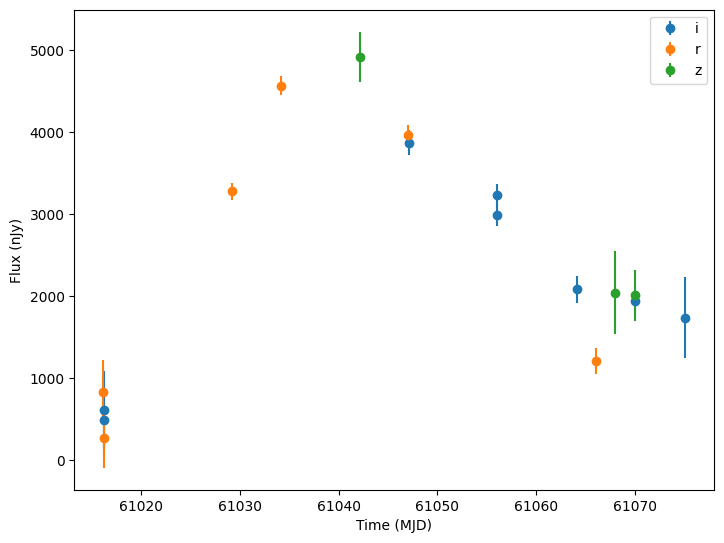

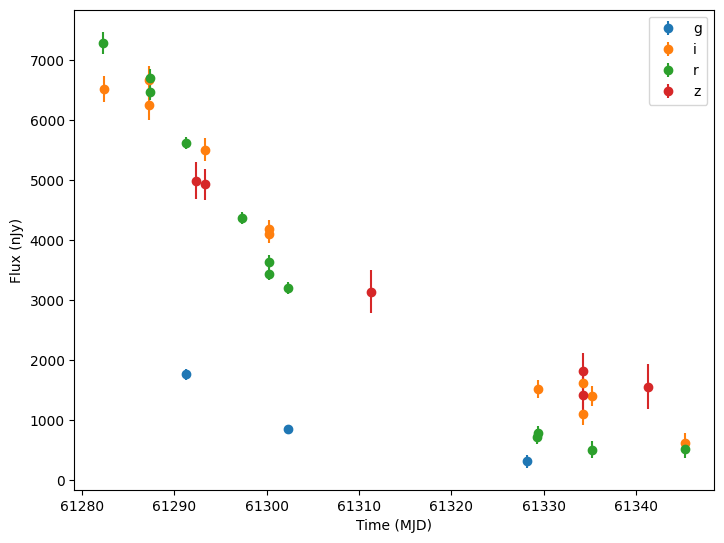

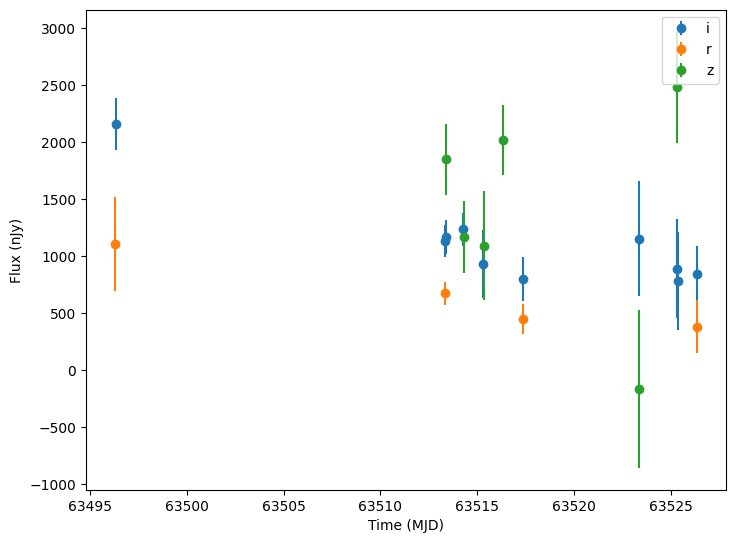

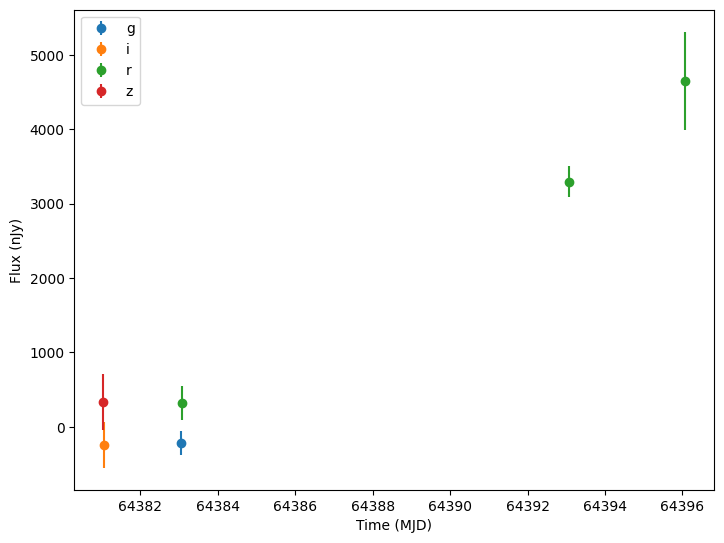

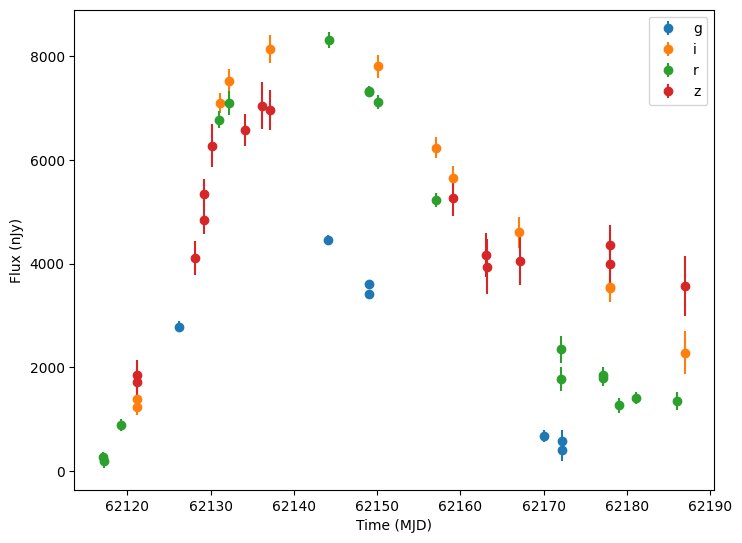

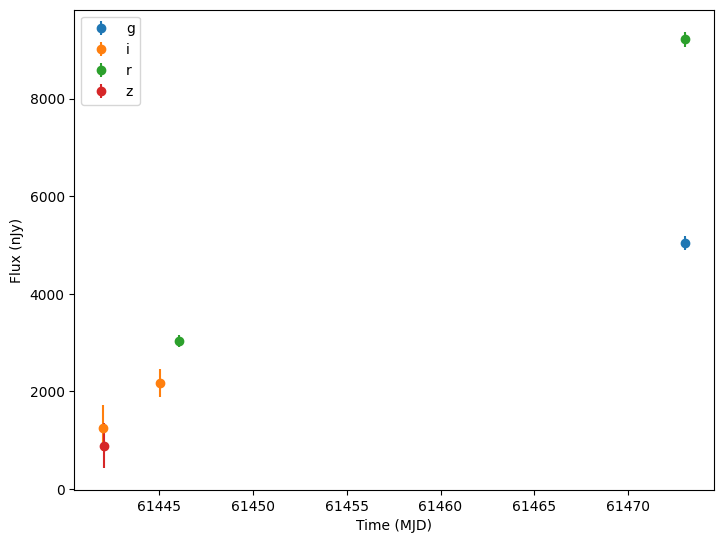

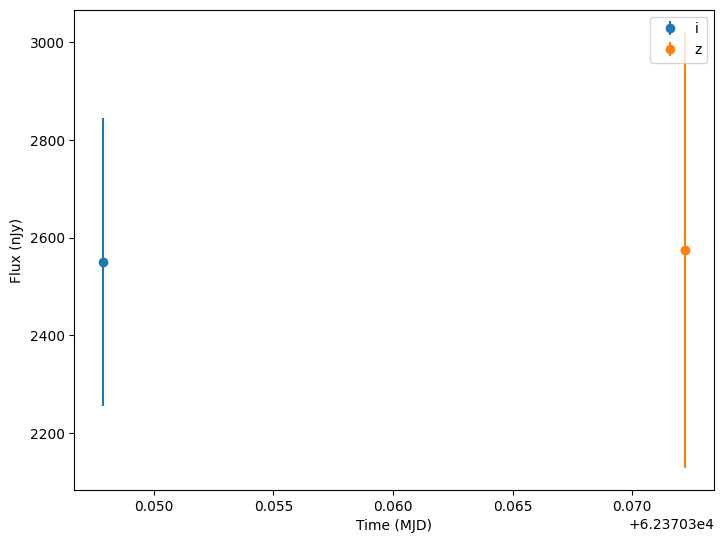

In [7]:
random_ids = np.random.choice(len(lightcurves), 10)

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.loc[random_id]

    if lc["nobs"] > 0:
        # Unpack the nested columns (filters, mjd, flux, and flux error).
        lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
        lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
        lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
        lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

        plot_lightcurves(
            fluxes=lc_flux,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
        )